# **Q12. Zee Recommender Systems**

## **Problem Statement:**
### 1. Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.


In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
)
from surprise import Dataset, Reader, SVD, NMF
from surprise.model_selection import train_test_split
import cmfrec
import itertools
import pylab
import missingno as msno
import warnings
#from fbprophet import Prophet
warnings.filterwarnings("ignore")

***
***
## **1. Defining Helper Functions.**

In [2]:
def convert_to_best_type(df):
    for column in df.columns:
        try:
            if np.any(df[column].apply(lambda x: '.' in str(x))):
                df[column] = df[column].astype('float64')
            else:
                if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                    df[column] = df[column].astype(bool)
                elif len(df[column].unique())<10:
                    df[column] = pd.Categorical(df[column])
                else:
                    df[column] = df[column].astype('int64')
        except:
            if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                df[column] = df[column].astype(bool)
            elif np.any(df[column].apply(lambda x: ':' in str(x))):
                df[column] = pd.to_datetime(df[column])
            elif len(df[column].unique())<10:
                df[column] = pd.Categorical(df[column])
            else:
                df[column] = df[column].astype('string')
    return df

In [3]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    outlier_fraction = (len(df_in)-len(df_out))/len(df_in)
    if outlier_fraction > 0.0:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(18,6))
        sns.boxplot(data=df_in, y=col_name)
        if outlier_fraction <= 0.10:
            fig.suptitle(f"Outliers constitute {round(outlier_fraction*100, 2)}% of data for column '{col_name}'. Hence removing outliers.", fontsize=20, color="green")
            plt.show()
            return df_out
        else:
            fig.suptitle(f"Outliers constitute significant amount of data ({round(outlier_fraction*100, 2)}%) for column '{col_name}'. Hence not removing outliers..", fontsize=20, color="green")
            plt.show()
            return df_in
    else:
        return df_in

In [4]:
df_movies = pd.read_csv('zee-movies.dat', encoding='ISO-8859-1', delimiter='::')
df_users = pd.read_csv('zee-users.dat', encoding='ISO-8859-1', delimiter='::')
df_ratings = pd.read_csv('zee-ratings.dat', encoding='ISO-8859-1', delimiter='::')

***
***
## **2. Analyzing Basic Metrics.**

In [54]:
print(f"Shape of Movies Dataframe: {df_movies.shape}")
print(f"Shape of Users Dataframe: {df_users.shape}")
print(f"Shape of Ratings Dataframe: {df_ratings.shape}")

Shape of Movies Dataframe: (3883, 21)
Shape of Users Dataframe: (6040, 5)
Shape of Ratings Dataframe: (1000209, 4)


***
***
## **3. Feature Engineering - Create new fields.**

In [5]:
df_movies.head()

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
df_movies['Genres'].str.split('|').explode().value_counts()

Drama          1603
Comedy         1200
Action          503
Thriller        492
Romance         471
Horror          343
Adventure       283
Sci-Fi          276
Children's      251
Crime           211
War             143
Documentary     127
Musical         114
Mystery         106
Animation       105
Fantasy          68
Western          68
Film-Noir        44
Name: Genres, dtype: int64

In [7]:
df_users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [8]:
occupation = {0: "other", 1: "academic/educator", 2: "artist", 3: "clerical/admin", 4: "college/grad student", 5: "customer service",
6: "doctor/health care", 7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer", 12: "programmer",
13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed", 17: "technician/engineer", 18: "tradesman/craftsman",
19: "unemployed", 20: "writer"}
df_users['Occupation'] = df_users['Occupation'].apply(lambda x: occupation[int(x)])

In [9]:
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [10]:
df_movies['release_year'] = df_movies['Title'].str.extract('\((\d+)\)')[0].astype('int')
df_movies['Title'] = df_movies['Title'].str.extract('(.*) \(\d+\)')[0]
df_movies = pd.concat([df_movies, df_movies['Genres'].str.get_dummies(sep = '|')], axis=1)
df_movies.drop(['Genres'], inplace=True, axis=1)
df_movies.rename(columns = {'Movie ID':'MovieID'}, inplace = True)

In [11]:
df_movies.head()

,MovieID,Title,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_ratings['Timestamp'] = pd.to_datetime(df_ratings['Timestamp'],unit='s')

In [13]:
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [14]:
df = df_ratings.merge(df_users).merge(df_movies)

In [15]:
df.head()

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,release_year,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1193,5,2000-12-31 22:12:40,F,1,K-12 student,48067,One Flew Over the Cuckoo's Nest,1975,...,0,0,0,0,0,0,0,0,0,0
1,2,1193,5,2000-12-31 21:33:33,M,56,self-employed,70072,One Flew Over the Cuckoo's Nest,1975,...,0,0,0,0,0,0,0,0,0,0
2,12,1193,4,2000-12-30 23:49:39,M,25,programmer,32793,One Flew Over the Cuckoo's Nest,1975,...,0,0,0,0,0,0,0,0,0,0
3,15,1193,4,2000-12-30 18:01:19,M,25,executive/managerial,22903,One Flew Over the Cuckoo's Nest,1975,...,0,0,0,0,0,0,0,0,0,0
4,17,1193,5,2000-12-30 06:41:11,M,50,academic/educator,95350,One Flew Over the Cuckoo's Nest,1975,...,0,0,0,0,0,0,0,0,0,0


***
***
## **4. Missing values handling.**

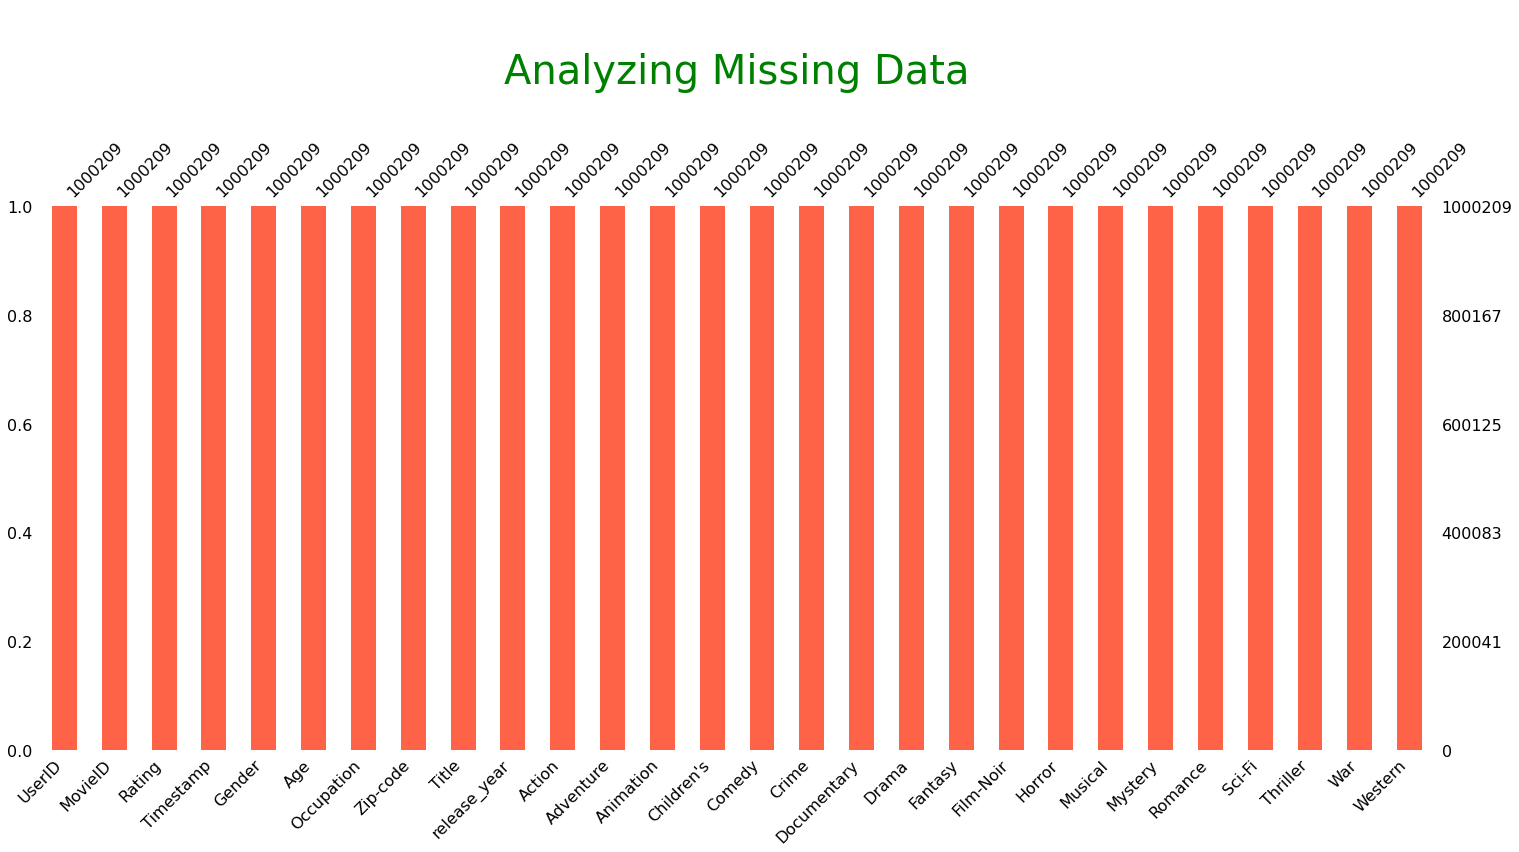

In [16]:
msno.bar(df, color='tomato')
plt.title("\nAnalyzing Missing Data\n", fontsize=40, color="green")
plt.show()

***
***
## **5. Rating stats per movies.**

In [17]:
df_ratings.groupby(['MovieID']).agg(mean_rating=('Rating', 'mean'), count_ratings=('Rating', 'count'))

,mean_rating,count_ratings
MovieID,,
1,4.146846,2077
2,3.201141,701
3,3.016736,478
4,2.729412,170
5,3.006757,296
...,...,...
3948,3.635731,862
3949,4.115132,304
3950,3.666667,54


***
***
## **6. User-Item Interaction Matrix.**

In [18]:
df_pivoted = df.pivot_table(index='UserID',columns='Title',values='Rating')
df_pivoted.fillna(0, inplace=True)

In [19]:
df_pivoted.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***
***
## **7. Pearson correlation based recommender.**

In [20]:
def simple_recommender_pearson_item_input(input_df, input_movie_title):
    input_series = input_df.loc[:, input_movie_title]
    return pd.Series(input_df.corrwith(input_series).sort_values(ascending=False)[1:6].index)

In [21]:
simple_recommender_pearson_item_input(df_pivoted, 'Toy Story')

0       Toy Story 2
1           Aladdin
2    Lion King, The
3     Groundhog Day
4     Bug's Life, A
Name: Title, dtype: object

In [22]:
simple_recommender_pearson_item_input(df_pivoted, 'Forrest Gump')

0            Pretty Woman
1                   Ghost
2    Sleepless in Seattle
3           Groundhog Day
4      As Good As It Gets
Name: Title, dtype: object

***
***
## **8. Item-Item Similarity Matrix (Cosine Similarity).**

In [23]:
# compute item similarity matrix
item_item_similarity = cosine_similarity(df_pivoted.T)
item_item_similarity_df = pd.DataFrame(item_item_similarity, index=df_pivoted.columns, columns=df_pivoted.columns)
item_item_similarity_df.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.00000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.00000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.08025,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.00000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All,0.060838,0.159526,0.066301,0.143620,1.000000,0.00000,0.075093,0.178928,0.205486,0.122431,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040


***
***
## **9. User-User Similarity Matrix (Cosine Similarity).**

In [24]:
# compute user similarity matrix
user_user_similarity = cosine_similarity(df_pivoted)
user_user_similarity_df = pd.DataFrame(user_user_similarity, index=df_pivoted.index, columns=df_pivoted.index)
user_user_similarity_df.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.096382,0.120610,0.132455,0.090158,0.179222,0.059678,0.138241,0.226148,0.254736,...,0.170588,0.082006,0.090961,0.033663,0.114877,0.186957,0.136233,0.000000,0.174604,0.133590
2,0.096382,1.000000,0.151479,0.171176,0.114394,0.100865,0.305787,0.211120,0.190198,0.227745,...,0.112503,0.091222,0.268565,0.014286,0.183384,0.229011,0.206660,0.066118,0.066457,0.218276
3,0.120610,0.151479,1.000000,0.151227,0.062907,0.074603,0.138332,0.077656,0.126457,0.214487,...,0.092960,0.125864,0.161507,0.000000,0.097308,0.143747,0.107945,0.120234,0.094675,0.133144
4,0.132455,0.171176,0.151227,1.000000,0.045094,0.013529,0.130339,0.100856,0.093651,0.121208,...,0.163629,0.093041,0.382803,0.000000,0.082097,0.171158,0.127703,0.062907,0.064634,0.137968
5,0.090158,0.114394,0.062907,0.045094,1.000000,0.047449,0.126257,0.220817,0.261330,0.117508,...,0.100652,0.035732,0.065278,0.054151,0.179083,0.294354,0.173009,0.020459,0.027689,0.241437


***
***
## **10. Similarity Based Recommender (User Input).**

In [25]:
def simple_recommender_cosine_user_input(user_id, df_pivoted, item_item_similarity_df, top_n=5):
    user_ratings = df_pivoted.loc[user_id, :]
    rated_items = user_ratings[user_ratings!=0.0].index
    unrated_items = user_ratings[user_ratings==0.0].index
    item_scores = item_item_similarity_df.loc[unrated_items, rated_items].dot(user_ratings[rated_items])
    top_items = item_scores.sort_values(ascending=False).head(top_n).index
    return pd.Series(top_items)

In [26]:
simple_recommender_cosine_user_input(3, df_pivoted, item_item_similarity_df)

0             Batman
1           Die Hard
2    Terminator, The
3        Matrix, The
4      Lethal Weapon
Name: Title, dtype: object

In [27]:
simple_recommender_cosine_user_input(10, df_pivoted, item_item_similarity_df)

0         Romancing the Stone
1       Good Morning, Vietnam
2    Who Framed Roger Rabbit?
3                    Die Hard
4                Total Recall
Name: Title, dtype: object

***
***
## **10. Similarity Based Recommender (Item Input).**

In [28]:
def simple_recommender_cosine_item_input(input_movie_title, item_item_similarity_df, top_n=5):
    return pd.Series(item_item_similarity_df[input_movie_title].sort_values(ascending=False)[1:1+top_n].index)

In [29]:
simple_recommender_cosine_item_input('Toy Story', item_item_similarity_df)

0           Toy Story 2
1         Groundhog Day
2               Aladdin
3         Bug's Life, A
4    Back to the Future
Name: Title, dtype: object

In [30]:
simple_recommender_cosine_item_input('Forrest Gump', item_item_similarity_df)

0         Groundhog Day
1    As Good As It Gets
2                 Ghost
3             Toy Story
4          Men in Black
Name: Title, dtype: object

***
***
## **11. KNN Based Recommender (User Input).**

In [31]:
def simple_recommender_knn_user_input(user_id, df_pivoted, item_item_similarity_df, k=5):
    k = 5 # number of neighbors to consider
    nn_model = NearestNeighbors(n_neighbors=k, metric='cosine')
    nn_model.fit(df_pivoted.T)
    user_ratings = df_pivoted.loc[user_id]
    rated_items = user_ratings[user_ratings!=0.0].index
    unrated_items = user_ratings[user_ratings==0.0].index
    _, item_indices = nn_model.kneighbors(df_pivoted.T.loc[rated_items].values)
    similar_items = item_indices.flatten()
    similar_unrated_items = np.intersect1d(df_pivoted.T.iloc[similar_items].index, unrated_items)
    item_scores = item_item_similarity_df.loc[similar_unrated_items, :].loc[:, rated_items].dot(user_ratings.loc[rated_items])
    item_scores /= item_item_similarity_df.loc[similar_unrated_items, :].loc[:, rated_items].sum(axis=1)
    item_scores = pd.DataFrame(item_scores, index=similar_unrated_items, columns=['score'])
    item_scores = item_scores.sort_values(by='score', ascending=False).head(5)
    recommended_items = item_scores.index.tolist()
    return pd.Series(recommended_items)

In [32]:
simple_recommender_knn_user_input(3, df_pivoted, item_item_similarity_df)

0    Deer Hunter, The
1           Tombstone
2          Sting, The
3             M*A*S*H
4    Bonnie and Clyde
dtype: object

In [33]:
simple_recommender_knn_user_input(10, df_pivoted, item_item_similarity_df)

0    Slappy and the Stinkers
1               Little Women
2          Circle of Friends
3         Little Princess, A
4                 Funny Face
dtype: object

***
***
## **12. KNN Based Recommender (Item Input).**

In [34]:
def simple_recommender_knn_item_input(input_movie_title, df_pivoted, item_item_similarity_df, k=5):
    k = 5 # number of neighbors to consider
    nn_model = NearestNeighbors(n_neighbors=k+1, metric='cosine')
    nn_model.fit(df_pivoted.T)
    _, item_indices = nn_model.kneighbors(np.array(df_pivoted.T.loc[input_movie_title]).reshape(1, -1))
    similar_items = item_indices.flatten()
    return pd.Series(df_pivoted.T.iloc[similar_items].index[1:])

In [35]:
simple_recommender_knn_item_input('Toy Story', df_pivoted, item_item_similarity_df)

0           Toy Story 2
1         Groundhog Day
2               Aladdin
3         Bug's Life, A
4    Back to the Future
Name: Title, dtype: object

In [36]:
simple_recommender_knn_item_input('Forrest Gump', df_pivoted, item_item_similarity_df)

0         Groundhog Day
1    As Good As It Gets
2                 Ghost
3             Toy Story
4          Men in Black
Name: Title, dtype: object

***
***
## **13. Matrix Factorisation - CMFREC (with train-test split).**

In [37]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['UserID', 'MovieID', 'Rating']], reader)

trainset, testset = train_test_split(data, test_size=0.3)
trainset_df = pd.DataFrame(trainset.build_testset(), columns=['UserId', 'ItemId', 'Rating'])

model = cmfrec.CMF(k=4)
model.fit(trainset_df)

Starting ALS optimization routine

Updating B ... done
Updating A ... done
	Completed ALS iteration  1

Updating B ... done
Updating A ... done
	Completed ALS iteration  2

Updating B ... done
Updating A ... done
	Completed ALS iteration  3

Updating B ... done
Updating A ... done
	Completed ALS iteration  4

Updating B ... done
Updating A ... done
	Completed ALS iteration  5

Updating B ... done
Updating A ... done
	Completed ALS iteration  6

Updating B ... done
Updating A ... done
	Completed ALS iteration  7

Updating B ... done
Updating A ... done
	Completed ALS iteration  8

Updating B ... done
Updating A ... done
	Completed ALS iteration  9

Updating B ... done
Updating A ... done
	Completed ALS iteration 10

ALS procedure terminated successfully


Collective matrix factorization model
(explicit-feedback variant)


***
***
## **14. Matrix Factorisation - CMFREC - Performance Metrics.**

In [38]:
predictions = model.predict([test[0] for test in testset], [test[1] for test in testset])
true_ratings = [r for (_, _, r) in testset]

rmse = np.sqrt(mse(true_ratings, predictions))
mape = np.mean(np.abs(true_ratings - predictions) / true_ratings)
smape = np.mean(np.abs(true_ratings - predictions) / np.abs(true_ratings + predictions)/2)

print("RMSE:", rmse)
print("MAPE:", mape)
print("sMAPE:", smape)

RMSE: 0.8642439395351863
MAPE: 0.2639890569551386
sMAPE: 0.05368942686290901


***
***
## **15. Matrix Factorisation - Surprise Library (d=4).**

In [39]:
# Load the ratings data into the Surprise dataset format
data = Dataset.load_from_df(df[['UserID', 'MovieID', 'Rating']], reader)

# Split the data into training and testing sets
trainset = data.build_full_trainset()

# Train the SVD algorithm with d=4
model = SVD(n_factors=4)
model.fit(trainset)

# Extract the item and user embeddings
item_embeddings = model.qi
user_embeddings = model.pu

# Compute the item-item and user-user similarity using cosine similarity
item_item_sim_matrix = cosine_similarity(item_embeddings)
item_item_sim_df = pd.DataFrame(item_item_sim_matrix, columns=trainset.ir, index=trainset.ir)
item_item_sim_df.index.name = 'movieId_1'
item_item_sim_df = item_item_sim_df.reset_index().melt(id_vars=['movieId_1'], var_name='movieId_2', value_name='similarity')

user_user_sim_matrix = cosine_similarity(user_embeddings)
user_user_sim_df = pd.DataFrame(user_user_sim_matrix, columns=trainset.ur, index=trainset.ur)
user_user_sim_df.index.name = 'userId_1'
user_user_sim_df = user_user_sim_df.reset_index().melt(id_vars=['userId_1'], var_name='userId_2', value_name='similarity')

In [40]:
item_item_sim_df.head()

,movieId_1,movieId_2,similarity
0,0,0,1.000000
1,1,0,0.990992
2,2,0,-0.140769
3,3,0,-0.446698
4,4,0,0.547606


In [41]:
user_user_sim_df.head()

,userId_1,userId_2,similarity
0,0,0,1.000000
1,1,0,0.646017
2,2,0,-0.516870
3,3,0,0.911072
4,4,0,-0.982408


***
***
## **16. Recommender based upon Surprise Library (Item Input).**

In [42]:
def simple_recommender_mf_item_input(input_movie_title, item_item_sim_df, top_n=5):
    movie_id = df[df['Title']==input_movie_title]['MovieID'].iloc[0]
    movie_ids = item_item_sim_df[item_item_sim_df['movieId_1'] == movie_id].sort_values(by='similarity', ascending=False)[1:6]['movieId_2']
    return pd.Series(df[df['MovieID'].isin(movie_ids)]['Title'].unique())

In [43]:
simple_recommender_mf_item_input('Toy Story', item_item_sim_df)

0             Heavy Metal
1                Bad Boys
2               Hairspray
3    Horse Whisperer, The
dtype: object

In [44]:
simple_recommender_mf_item_input('Forrest Gump', item_item_sim_df)

0     Friday the 13th
1    Winslow Boy, The
2             Timecop
3              Nadine
4          Dear Jesse
dtype: object

***
***
## **17. User and Item Embeddings (d=4).**

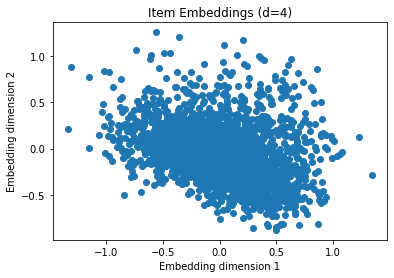

In [45]:
plt.scatter(item_embeddings[:, 0], item_embeddings[:, 1])
plt.xlabel('Embedding dimension 1')
plt.ylabel('Embedding dimension 2')
plt.title('Item Embeddings (d=4)')
plt.show()

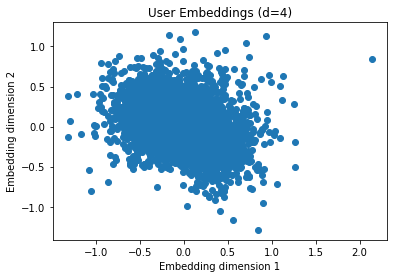

In [46]:
plt.scatter(user_embeddings[:, 0], user_embeddings[:, 1])
plt.xlabel('Embedding dimension 1')
plt.ylabel('Embedding dimension 2')
plt.title('User Embeddings (d=4)')
plt.show()

***
***
## **18. Matrix Factorisation - Surprise Library (d=2).**

In [47]:
# Load the ratings data into the Surprise dataset format
data = Dataset.load_from_df(df[['UserID', 'MovieID', 'Rating']], reader)

# Split the data into training and testing sets
trainset = data.build_full_trainset()

# Train the SVD algorithm with d=2
model = SVD(n_factors=2)
model.fit(trainset)

# Extract the item and user embeddings
item_embeddings = model.qi
user_embeddings = model.pu

# Compute the item-item and user-user similarity using cosine similarity
item_item_sim_matrix = cosine_similarity(item_embeddings)
item_item_sim_df = pd.DataFrame(item_item_sim_matrix, columns=trainset.ir, index=trainset.ir)
item_item_sim_df.index.name = 'movieId_1'
item_item_sim_df = item_item_sim_df.reset_index().melt(id_vars=['movieId_1'], var_name='movieId_2', value_name='similarity')

user_user_sim_matrix = cosine_similarity(user_embeddings)
user_user_sim_df = pd.DataFrame(user_user_sim_matrix, columns=trainset.ur, index=trainset.ur)
user_user_sim_df.index.name = 'userId_1'
user_user_sim_df = user_user_sim_df.reset_index().melt(id_vars=['userId_1'], var_name='userId_2', value_name='similarity')

***
***
## **19. Recommender based upon Surprise Library (Item Input).**

In [48]:
simple_recommender_mf_item_input('Toy Story', item_item_sim_df)

0           Indecent Proposal
1    Children of the Corn III
2              Love and a .45
3              Santa Fe Trail
4       In the Line of Duty 2
dtype: object

In [49]:
simple_recommender_mf_item_input('Forrest Gump', item_item_sim_df)

0    Dark Crystal, The
1    Santa Clause, The
2      Midnight Cowboy
3      King Kong Lives
4              Foolish
dtype: object

***
***
## **20. User and Item Embeddings (d=2).**

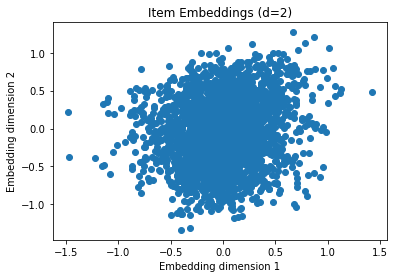

In [50]:
plt.scatter(item_embeddings[:, 0], item_embeddings[:, 1])
plt.xlabel('Embedding dimension 1')
plt.ylabel('Embedding dimension 2')
plt.title('Item Embeddings (d=2)')
plt.show()

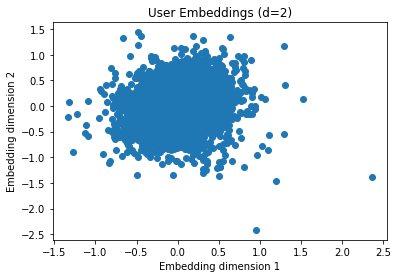

In [51]:
plt.scatter(user_embeddings[:, 0], user_embeddings[:, 1])
plt.xlabel('Embedding dimension 1')
plt.ylabel('Embedding dimension 2')
plt.title('User Embeddings (d=2)')
plt.show()

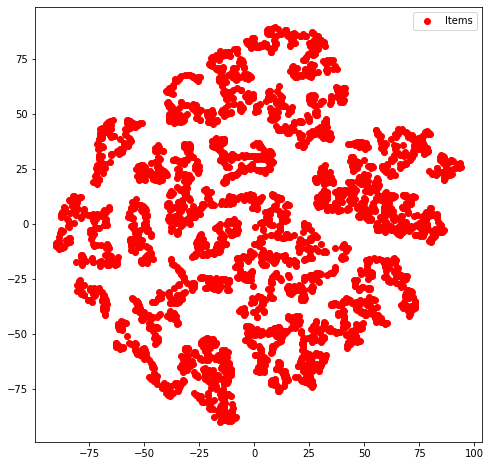

In [52]:
# Combine the embeddings and assign indices
all_embeddings = np.concatenate([item_embeddings, user_embeddings])
index = np.arange(all_embeddings.shape[0])

# Compute t-SNE embedding
tsne = TSNE(n_components=2, random_state=0)
tsne_embeddings = tsne.fit_transform(all_embeddings)

# Plot the t-SNE embeddings, with item embeddings in red and user embeddings in blue
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(tsne_embeddings[:item_embeddings.shape[0], 0], tsne_embeddings[:item_embeddings.shape[0], 1], color='red', label='Items')
ax.legend()
plt.show()

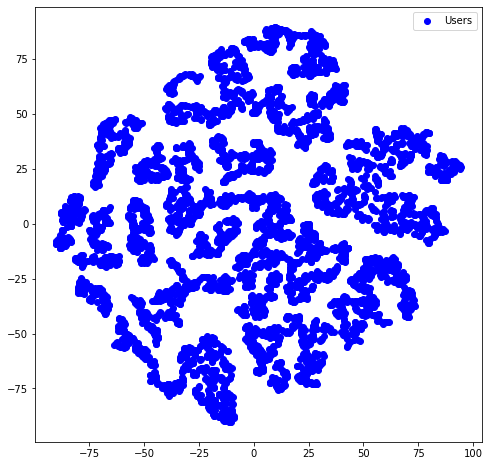

In [53]:
# Plot the t-SNE embeddings, with item embeddings in red and user embeddings in blue
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(tsne_embeddings[item_embeddings.shape[0]:, 0], tsne_embeddings[item_embeddings.shape[0]:, 1], color='blue', label='Users')
ax.legend()
plt.show()

***
***
## **21. Questionnaire.**

***
### 1. Users of which age group have watched and rated the most number of movies? ###

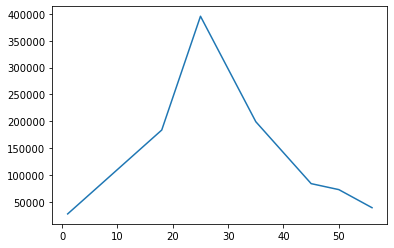

In [68]:
plt.plot(df_ratings.merge(df_users).groupby('Age')['MovieID'].count())

### Ans. Age group 20-30 ###

***
### 2. Users belonging to which profession have watched and rated the most movies? ###

In [80]:
df_ratings.merge(df_users).groupby('Occupation')['MovieID'].count().sort_values(ascending=False)[:5]

Occupation
college/grad student    131032
other                   130499
executive/managerial    105425
academic/educator        85351
technician/engineer      72816
Name: MovieID, dtype: int64

### Ans. College and Grad students have watched and rated most number of movies. ###

***
### 3. Most of the users in our dataset who’ve rated the movies are Male. (T/F) ###

In [81]:
df_ratings.merge(df_users).groupby('Gender')['MovieID'].count().sort_values(ascending=False)[:5]

Gender
M    753769
F    246440
Name: MovieID, dtype: int64

### Ans. True. ###

***
### 4. Most of the movies present in our dataset were released in which decade? ###

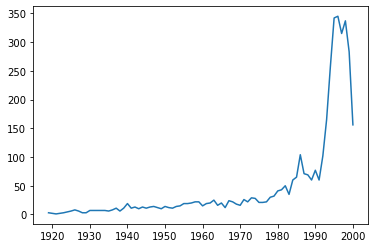

In [86]:
plt.plot(df_movies.groupby('release_year')['MovieID'].count())

### Ans. Decade of 1991-2000. ###

***
### 5. The movie with maximum no. of ratings is ___. ###

In [100]:
movie_id = df_ratings.groupby('MovieID')['Rating'].count().sort_values(ascending=False).index[0]
df_movies[df_movies['MovieID']==movie_id]['Title']

2789    American Beauty
Name: Title, dtype: object

### Ans. American Beauty. ###

***
### 6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach. ###

In [102]:
simple_recommender_knn_item_input('Liar Liar', df_pivoted, item_item_similarity_df)[:3]

0                Mrs. Doubtfire
1    Ace Ventura: Pet Detective
2                 Dumb & Dumber
Name: Title, dtype: object

### 7. On the basis of approach, Collaborative Filtering methods can be classified into ___-based and ___-based. ###

### Ans: 1. Memory Based (User-User/Item-Item based). 2. Model Based (Matrix Factorisation). ###

***
### 8. Pearson Correlation ranges between ___ to ___ whereas, Cosine Similarity belongs to the interval between ___ to ___. ###

### Ans. Pearson Correlation coefficient ranges between -1 to 1, whereas Cosine Similarity belongs to the interval between 0 to 1. ###

***
### 9. Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model. ###

### Ans. ###
#### RMSE: 0.8642439395351863 ####
#### MAPE: 0.2639890569551386 ####
#### sMAPE: 0.05368942686290901 ####

***
### 10. Give the sparse ‘row’ matrix representation for the following dense matrix - ###
#### [[1 0] ####
#### [3 7]] ####

### Ans. ###
#### The sparse 'row' matrix representation (in CSR form) is: ####
#### data: [1, 3, 7] ####
#### indices: [0, 0, 1] ####
#### indptr: [0, 1, 3] ####